In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:
def mostrar(categories, data_dir, num_imgs_por_clase):
    fig, axes = plt.subplots(len(categories), num_imgs_por_clase, figsize=(12, 3 * len(categories)))

    for i, category in enumerate(categories):
        folder = os.path.join(data_dir, category)
        files = os.listdir(folder)
        muestras = random.sample(files, num_imgs_por_clase) if len(files) >= num_imgs_por_clase else files

        for j in range(len(muestras)):
            img_path = os.path.join(folder, muestras[j])
            img = cv2.imread(img_path)

            ax = axes[i, j] if len(categories) > 1 else axes[j]
            ax.imshow(img, cmap="gray", vmin=0, vmax=255)
            ax.axis('off')

            if j == 1:
                ax.set_title(category, fontsize=10)

    plt.tight_layout()
    plt.show()
data_dir = r"C:\Users\user\OneDrive\Escritorio\Vacas\Caras"
categorias = os.listdir(data_dir)
mostrar(categorias, data_dir, 3)

# Pytorch Dataset

In [29]:
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import json
from torchvision.transforms import transforms
import random
from torch.utils.data import Dataset

def get_df(path, minimo_numero_imagenes):
  filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path)
              for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
  labels = [os.path.basename(os.path.dirname(path)) for path in filepaths]
  df = pd.DataFrame({'filepath': filepaths, 'label': labels})
  # se filtran las clases con menos de 11 imagenes par ano tener problemas con la creacion de tripletas
  df = df.groupby("label").filter(lambda grp: len(grp) > minimo_numero_imagenes)
  # Se crea una galeria para simular un sistema en produccion 
  gallery_df = (df.groupby('label', group_keys=False).apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True))
  return df, gallery_df

def split_df(df, test_val_size, test_size):
  train_df, test_val_df = train_test_split(df, test_size=test_val_size, random_state=13)
  test_df, val_df = train_test_split(test_val_df, test_size= test_size, random_state=13)
  print("Total de imágenes:", len(df))
  print("Entrenamiento:", len(train_df))
  print("Validación:", len(val_df))
  print("Test:", len(test_df))
  print("Labels: ", df["label"].unique(),"\nNumero de clases unicas: ", len(df["label"].unique()))
  return train_df, val_df, test_df

class CowsTripletsDataset(Dataset):
    '''clase para generar un dataset de tripletas ancla, positiva y negativa'''
    def __init__(self, df=None,path=None, transform=None):
        self.transform = transform
        # path original
        self.path = path
        self.df = df
        self.images = self.df['filepath'].values
        self.labels = self.df['label'].values
        self.index = np.arange(len(self.images))

    def __len__(self):
      return len(self.images)

    def __getitem__(self, item):
        ###### Anchor Image #######
        anchor_image_path = self.images[item]
        anchor_img = Image.open(anchor_image_path)
            #### Anchor label #####
        anchor_label = self.labels[item]
        #### Positive Image ####
        ##### Lista de imagenes de la misma clase para obtener el ancla
        positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
        ##### Se elige una imagen al azar de la misma clase
        positive_item = random.choice(positive_list)
        positive_image_path = self.images[positive_item]
        positive_img = Image.open(positive_image_path)
        ######## Negative Image #####
        negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        negative_image_path = self.images[negative_item]
        negative_img = Image.open(negative_image_path)
        if self.transform!=None:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)
        return anchor_img, positive_img, negative_img, anchor_label
    
class CowSingle(Dataset):
    """Devuelve imagen, label  sin trípletas para  test."""
    def __init__(self, df, transform=None):
        self.imgs = df['filepath'].values
        self.labs = df['label'].values
        self.tf   = transform

    def __len__(self): return len(self.imgs)

    def __getitem__(self, i):
        img = Image.open(self.imgs[i])
        if self.tf: img = self.tf(img)
        return img, self.labs[i]


def get_face_datasets(train_df, val_df, test_df, gallery_df, train_transforms, eval_transforms):
  train_dataset = CowsTripletsDataset(df=train_df, transform=train_transforms)
  val_dataset = CowsTripletsDataset(df=val_df, transform=eval_transforms)
  test_dataset = CowSingle(df=test_df, transform=eval_transforms)
  gallery_dataset = CowSingle(df=gallery_df, transform=eval_transforms)
  return train_dataset, val_dataset, test_dataset, gallery_dataset

def get_face_dataloaders(train_dataset, val_dataset, test_dataset,gallery_dataset,batch_size):
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  gallery_dataloader = DataLoader(gallery_dataset, batch_size=batch_size, shuffle=False)
  return train_dataloader, val_dataloader, test_dataloader, gallery_dataloader




In [ ]:
# Se carga el dataset
df, gallery_df = get_df(r"C:\Users\user\OneDrive\Escritorio\Vacas\Caras", 9)
train_df, val_df, test_df = split_df(df, 0.3, 0.5)

Total de imágenes: 2348
Entrenamiento: 1643
Validación: 353
Test: 352
Labels:  ['02 rojo' '06 rojo' '10 rojo' '14 rojo' '16 rojo' '21 rojo' '23 rojo'
 '43 rojo' '45 amarillo' '49 rojo' '5 rojo' '53 amarillo' '54 amarillo'
 '58 amarillo' '60 amarillo' '61 amarillo' '62 amarillo' '622 naranja'
 '635' '635 naranja' '637 naranja' '638 naranja' '65 amarillo'
 '651 naranja' '68 amarillo' '82 amarillo' '87' '879 amarillo'
 '888 amarillo' 'Blanca sin orejera' 'n2005'
 'Negra sin orejera un solo cacho' 's114' 's1547' 's1556' 's1557' 's1607'
 's1641' 's1706' 's1774' 's1778' 's1797' 's1804' 's1805' 's1843' 's1853'
 's1854' 's1868' 's1870' 's1896' 's1903' 's1906' 's1914' 's1935' 's2011'
 's377' 's5562' 's7704' 's8803' 's8804' 's8813' 's8819' 's8832' 's8835'
 's8843' 'sn1125' 'sn13' 'sn1761' 'sn19' 'sn20' 'sn22' 'sn23'
 'Vaca sin orejera con oreja cortada' 'Vaca sin orejera ganado de leche'] 
Numero de clases unicas:  74


C:\Users\user\AppData\Local\Temp\ipykernel_27520\2575983530.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gallery_df = (df.groupby('label', group_keys=False).apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True))


In [21]:
from torchvision import transforms

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# ───────────────────────────────────
# a) versión de entrenamiento (data-aug)
# ───────────────────────────────────
train_tfms = {
    "resnet": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
    "inception": transforms.Compose([
        transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
,
    "vit": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
}

# ───────────────────────────────────
# b) versión de validación / test
# ───────────────────────────────────
eval_tfms = {
    "resnet": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
    "inception": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    ,
    "vit": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]),
}


# TripletLoss

In [22]:
class TripletLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        # margin es una constante que le agrega peso al loss
        self.margin = margin
    def calc_euclidean(self, x1, x2):
        # distancia euclidiana
        return (x1 - x2).pow(2).sum(1)
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        # distancia entre el ancla y la postiva
        distance_positive = self.calc_euclidean(anchor, positive)
        # distnacia entre el ancla y la negativa
        distance_negative = self.calc_euclidean(anchor, negative)
        # se aplica la formula de triplet loss distancia positva - distancia negativa + margen
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

# Feature Extractors

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models



# ────────────────────────────
# 1.  ResNet extractor
# ────────────────────────────
class ResNetExtractor(nn.Module):
    def __init__(self, k_freeze=3, pretrained=True, arch='resnet18'):
        """
        k_freeze = nº de *bloques* iniciales a congelar (0 = nada).
        En ResNet el orden es: stem, layer1, layer2, layer3, layer4.
        """
        super().__init__()
        if arch == 'resnet18':
            net = models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        elif arch == 'resnet34':
            net = models.resnet34(weights="IMAGENET1K_V1" if pretrained else None)
        elif arch == 'resnet50':
            net = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
        elif arch == 'resnet101':
            net = models.resnet101(weights="IMAGENET1K_V1" if pretrained else None)
        elif arch == 'resnet152':
            net = models.resnet152(weights="IMAGENET1K_V1" if pretrained else None)
        self.body = nn.Sequential(*list(net.children())[:-1])   # sin FC
        self.out_dim = net.fc.in_features

        # congela primeros k bloques
        for blk in list(self.body.children())[:k_freeze]:
            blk.requires_grad_(False)

    def forward(self, x):
        feat = self.body(x).flatten(1)    # [B, out_dim]
        return F.normalize(feat, p=2, dim=1)        # [B, out_dim]


# ────────────────────────────
# 3.  Inception extractor
# ────────────────────────────
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class InceptionExtractor(nn.Module):
    """
    Extrae embeddings de un modelo Inception v3 y los normaliza L2.

    Args:
        k_freeze (int): número de capas iniciales a congelar (0 = ninguna).
        pretrained (bool): si True, carga pesos preentrenados ImageNet.
    """
    def __init__(self, k_freeze: int = 2, pretrained: bool = True):
        super().__init__()
        # Cargar Inception v3 con aux_logits habilitado si se desea
        self.net = models.inception_v3(
            weights=models.Inception_V3_Weights.IMAGENET1K_V1 if pretrained else None,
            aux_logits=True
        )
        # Reemplazar la capa final fc por identidad para obtener features
        self.net.fc = nn.Identity()
        self.out_dim = 2048

        # Congelar capas iniciales según k_freeze
        children = list(self.net.children())
        for layer in children[:k_freeze]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: tensor de imágenes [B, C, H, W]
        Returns:
            embeddings L2-normalizados de tamaño [B, out_dim]
        """
        out = self.net(x)
        # Inception v3 puede retornar named tuple con .logits cuando aux_logits=True
        if hasattr(out, 'logits'):
            feat = out.logits
        elif isinstance(out, tuple):
            # Salida (logits, aux_logits)
            feat = out[0]
        else:
            feat = out
        # Normalizar L2
        feat = F.normalize(feat.view(feat.size(0), -1), p=2, dim=1)
        return feat




# ────────────────────────────
# 4.  ViT extractor
# ────────────────────────────
class ViTExtractor(nn.Module):
    def __init__(self, name="vit_small_patch16_224", k_freeze=4, pretrained=True):
        """
        k_freeze = nº de bloques Transformer a congelar
                   (ViT-Small tiene 12 bloques).
        """
        super().__init__()
        self.body = timm.create_model(
            name, pretrained=pretrained, num_classes=0, global_pool="avg"
        )
        self.out_dim = self.body.num_features

        for blk in self.body.blocks[:k_freeze]:
            blk.requires_grad_(False)

    def forward(self, x):
        return self.body(x)                     # ya es [B, out_dim]




# Embedding head

In [24]:
class EmbeddingHead(nn.Module):
    """
    Recibe un extractor (cualquiera de arriba) y lo usa internamente.
    Llama:  emb = embedder(img)   ← sin escribir extractor(img) aparte.
    """
    def __init__(self, extractor: nn.Module, emb_dim: int = 128):
        super().__init__()
        self.extractor = extractor
        self.proj = nn.Linear(extractor.out_dim, emb_dim)

    def forward(self, x):
        feats = self.extractor(x)
        emb = self.proj(feats)
        return F.normalize(emb, p=2, dim=1)


# Funcion de entrenamiento

In [26]:
from tqdm import tqdm
def train_val(embedder, EPOCHS, train_dataloader, val_dataloader, device, optimizer, criterion, scheduler ):
    train_losses = []
    val_losses   = []
    for epoch in tqdm(range(EPOCHS), desc='Epochs'):
        # ——— Entrenamiento ———
        embedder.train()
        running_loss = []
        for anchor_img, positive_img, negative_img, _ in tqdm(train_dataloader, desc='Training', leave=False):
            anchor_img, positive_img, negative_img = (t.to(device) for t in (anchor_img, positive_img, negative_img))

            optimizer.zero_grad()
            ea = embedder(anchor_img)
            ep = embedder(positive_img)
            en = embedder(negative_img)

            loss = criterion(ea, ep, en)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())

        mean_train = np.mean(running_loss)
        train_losses.append(mean_train)

        # ——— Validación ———
        val_running = []
        embedder.eval()
        with torch.no_grad():
            for anchor_img, positive_img, negative_img, _ in val_dataloader:
                anchor_img, positive_img, negative_img = (t.to(device) for t in (anchor_img, positive_img, negative_img))
                ea = embedder(anchor_img)
                ep = embedder(positive_img)
                en = embedder(negative_img)
                val_running.append(criterion(ea, ep, en).item())
        

        mean_val = np.mean(val_running)
        val_losses.append(mean_val)

        scheduler.step(mean_val)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: LR={current_lr:.2e} — Train Loss={mean_train:.4f} — Val Loss={mean_val:.4f}")


    # ——— Al final, dibuja las curvas ———
    epochs = list(range(1, EPOCHS+1))
    plt.figure(figsize=(5,5))
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses,   label='Val')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Entrenamiento Resnet18

Epochs:   1%|          | 1/100 [00:23<38:46, 23.50s/it]

Epoch 1: LR=1.00e-04 — Train Loss=0.2716 — Val Loss=0.1391


Epochs:   2%|▏         | 2/100 [00:47<38:25, 23.53s/it]

Epoch 2: LR=1.00e-04 — Train Loss=0.0931 — Val Loss=0.1131


Epochs:   3%|▎         | 3/100 [01:10<37:55, 23.46s/it]

Epoch 3: LR=1.00e-04 — Train Loss=0.0568 — Val Loss=0.0673


Epochs:   4%|▍         | 4/100 [01:33<37:17, 23.30s/it]

Epoch 4: LR=1.00e-04 — Train Loss=0.0510 — Val Loss=0.0659


Epochs:   5%|▌         | 5/100 [01:56<36:53, 23.30s/it]

Epoch 5: LR=1.00e-04 — Train Loss=0.0428 — Val Loss=0.0705


Epochs:   6%|▌         | 6/100 [02:19<36:23, 23.23s/it]

Epoch 6: LR=1.00e-04 — Train Loss=0.0382 — Val Loss=0.0603


Epochs:   7%|▋         | 7/100 [02:42<35:56, 23.19s/it]

Epoch 7: LR=1.00e-04 — Train Loss=0.0306 — Val Loss=0.0512


Epochs:   8%|▊         | 8/100 [03:06<35:37, 23.23s/it]

Epoch 8: LR=1.00e-04 — Train Loss=0.0261 — Val Loss=0.0583


Epochs:   9%|▉         | 9/100 [03:29<35:08, 23.17s/it]

Epoch 9: LR=1.00e-04 — Train Loss=0.0265 — Val Loss=0.0764


Epochs:  10%|█         | 10/100 [03:52<34:44, 23.16s/it]

Epoch 10: LR=1.00e-04 — Train Loss=0.0161 — Val Loss=0.0455


Epochs:  11%|█         | 11/100 [04:15<34:19, 23.14s/it]

Epoch 11: LR=1.00e-04 — Train Loss=0.0202 — Val Loss=0.0861


Epochs:  12%|█▏        | 12/100 [04:38<34:03, 23.22s/it]

Epoch 12: LR=1.00e-04 — Train Loss=0.0161 — Val Loss=0.0655


Epochs:  13%|█▎        | 13/100 [05:02<33:43, 23.26s/it]

Epoch 13: LR=1.00e-04 — Train Loss=0.0149 — Val Loss=0.0396


Epochs:  14%|█▍        | 14/100 [05:25<33:15, 23.20s/it]

Epoch 14: LR=1.00e-04 — Train Loss=0.0146 — Val Loss=0.0464


Epochs:  15%|█▌        | 15/100 [05:48<32:49, 23.17s/it]

Epoch 15: LR=1.00e-04 — Train Loss=0.0090 — Val Loss=0.0442


Epochs:  16%|█▌        | 16/100 [06:12<32:37, 23.30s/it]

Epoch 16: LR=1.00e-04 — Train Loss=0.0155 — Val Loss=0.0474


Epochs:  17%|█▋        | 17/100 [06:35<32:25, 23.44s/it]

Epoch 17: LR=1.00e-04 — Train Loss=0.0102 — Val Loss=0.0528


Epochs:  18%|█▊        | 18/100 [06:59<32:02, 23.44s/it]

Epoch 18: LR=1.00e-04 — Train Loss=0.0088 — Val Loss=0.0398


Epochs:  19%|█▉        | 19/100 [07:22<31:39, 23.46s/it]

Epoch 19: LR=1.00e-04 — Train Loss=0.0080 — Val Loss=0.0360


Epochs:  20%|██        | 20/100 [07:46<31:20, 23.50s/it]

Epoch 20: LR=1.00e-04 — Train Loss=0.0081 — Val Loss=0.0409


Epochs:  21%|██        | 21/100 [08:09<30:54, 23.47s/it]

Epoch 21: LR=1.00e-04 — Train Loss=0.0110 — Val Loss=0.0348


Epochs:  22%|██▏       | 22/100 [08:32<30:22, 23.37s/it]

Epoch 22: LR=1.00e-04 — Train Loss=0.0098 — Val Loss=0.0465


Epochs:  23%|██▎       | 23/100 [08:56<29:59, 23.37s/it]

Epoch 23: LR=1.00e-04 — Train Loss=0.0070 — Val Loss=0.0331


Epochs:  24%|██▍       | 24/100 [09:19<29:40, 23.43s/it]

Epoch 24: LR=1.00e-04 — Train Loss=0.0084 — Val Loss=0.0407


Epochs:  25%|██▌       | 25/100 [09:43<29:15, 23.41s/it]

Epoch 25: LR=1.00e-04 — Train Loss=0.0065 — Val Loss=0.0271


Epochs:  26%|██▌       | 26/100 [10:06<28:52, 23.41s/it]

Epoch 26: LR=1.00e-04 — Train Loss=0.0067 — Val Loss=0.0406


Epochs:  27%|██▋       | 27/100 [10:30<28:28, 23.40s/it]

Epoch 27: LR=1.00e-04 — Train Loss=0.0072 — Val Loss=0.0467


Epochs:  28%|██▊       | 28/100 [10:53<28:09, 23.46s/it]

Epoch 28: LR=1.00e-04 — Train Loss=0.0075 — Val Loss=0.0484


Epochs:  29%|██▉       | 29/100 [11:17<27:47, 23.49s/it]

Epoch 29: LR=1.00e-04 — Train Loss=0.0085 — Val Loss=0.0381


Epochs:  30%|███       | 30/100 [11:40<27:24, 23.50s/it]

Epoch 30: LR=1.00e-04 — Train Loss=0.0071 — Val Loss=0.0322


Epochs:  31%|███       | 31/100 [12:04<27:04, 23.55s/it]

Epoch 31: LR=1.00e-04 — Train Loss=0.0059 — Val Loss=0.0218


Epochs:  32%|███▏      | 32/100 [12:27<26:40, 23.53s/it]

Epoch 32: LR=1.00e-04 — Train Loss=0.0067 — Val Loss=0.0237


Epochs:  33%|███▎      | 33/100 [12:51<26:13, 23.49s/it]

Epoch 33: LR=1.00e-04 — Train Loss=0.0040 — Val Loss=0.0235


Epochs:  34%|███▍      | 34/100 [13:14<25:46, 23.44s/it]

Epoch 34: LR=1.00e-04 — Train Loss=0.0040 — Val Loss=0.0353


Epochs:  35%|███▌      | 35/100 [13:38<25:25, 23.47s/it]

Epoch 35: LR=1.00e-04 — Train Loss=0.0071 — Val Loss=0.0360


Epochs:  36%|███▌      | 36/100 [14:01<24:59, 23.43s/it]

Epoch 36: LR=1.00e-04 — Train Loss=0.0071 — Val Loss=0.0474


Epochs:  37%|███▋      | 37/100 [14:24<24:33, 23.38s/it]

Epoch 37: LR=5.00e-05 — Train Loss=0.0060 — Val Loss=0.0466


Epochs:  38%|███▊      | 38/100 [14:47<24:06, 23.33s/it]

Epoch 38: LR=5.00e-05 — Train Loss=0.0041 — Val Loss=0.0372


Epochs:  39%|███▉      | 39/100 [15:11<23:43, 23.34s/it]

Epoch 39: LR=5.00e-05 — Train Loss=0.0031 — Val Loss=0.0282


Epochs:  40%|████      | 40/100 [15:34<23:20, 23.34s/it]

Epoch 40: LR=5.00e-05 — Train Loss=0.0039 — Val Loss=0.0200


Epochs:  41%|████      | 41/100 [15:58<22:58, 23.37s/it]

Epoch 41: LR=5.00e-05 — Train Loss=0.0017 — Val Loss=0.0187


Epochs:  42%|████▏     | 42/100 [16:21<22:36, 23.39s/it]

Epoch 42: LR=5.00e-05 — Train Loss=0.0014 — Val Loss=0.0134


Epochs:  43%|████▎     | 43/100 [16:44<22:13, 23.40s/it]

Epoch 43: LR=5.00e-05 — Train Loss=0.0024 — Val Loss=0.0264


Epochs:  44%|████▍     | 44/100 [17:08<21:48, 23.37s/it]

Epoch 44: LR=5.00e-05 — Train Loss=0.0045 — Val Loss=0.0282


Epochs:  45%|████▌     | 45/100 [17:31<21:23, 23.34s/it]

Epoch 45: LR=5.00e-05 — Train Loss=0.0032 — Val Loss=0.0231


Epochs:  46%|████▌     | 46/100 [17:54<21:00, 23.33s/it]

Epoch 46: LR=5.00e-05 — Train Loss=0.0015 — Val Loss=0.0282


Epochs:  47%|████▋     | 47/100 [18:18<20:37, 23.34s/it]

Epoch 47: LR=5.00e-05 — Train Loss=0.0018 — Val Loss=0.0213


Epochs:  48%|████▊     | 48/100 [18:41<20:12, 23.31s/it]

Epoch 48: LR=2.50e-05 — Train Loss=0.0031 — Val Loss=0.0215


Epochs:  49%|████▉     | 49/100 [19:05<19:53, 23.40s/it]

Epoch 49: LR=2.50e-05 — Train Loss=0.0022 — Val Loss=0.0214


Epochs:  50%|█████     | 50/100 [19:28<19:32, 23.45s/it]

Epoch 50: LR=2.50e-05 — Train Loss=0.0024 — Val Loss=0.0394


Epochs:  51%|█████     | 51/100 [19:52<19:12, 23.52s/it]

Epoch 51: LR=2.50e-05 — Train Loss=0.0015 — Val Loss=0.0228


Epochs:  52%|█████▏    | 52/100 [20:15<18:48, 23.50s/it]

Epoch 52: LR=2.50e-05 — Train Loss=0.0008 — Val Loss=0.0108


Epochs:  53%|█████▎    | 53/100 [20:39<18:25, 23.51s/it]

Epoch 53: LR=2.50e-05 — Train Loss=0.0014 — Val Loss=0.0211


Epochs:  54%|█████▍    | 54/100 [21:02<17:57, 23.42s/it]

Epoch 54: LR=2.50e-05 — Train Loss=0.0011 — Val Loss=0.0157


Epochs:  55%|█████▌    | 55/100 [21:25<17:34, 23.44s/it]

Epoch 55: LR=2.50e-05 — Train Loss=0.0018 — Val Loss=0.0216


Epochs:  56%|█████▌    | 56/100 [21:49<17:08, 23.38s/it]

Epoch 56: LR=2.50e-05 — Train Loss=0.0006 — Val Loss=0.0209


Epochs:  57%|█████▋    | 57/100 [22:12<16:45, 23.39s/it]

Epoch 57: LR=2.50e-05 — Train Loss=0.0014 — Val Loss=0.0188


Epochs:  58%|█████▊    | 58/100 [22:36<16:22, 23.39s/it]

Epoch 58: LR=1.25e-05 — Train Loss=0.0010 — Val Loss=0.0255


Epochs:  59%|█████▉    | 59/100 [22:59<15:58, 23.38s/it]

Epoch 59: LR=1.25e-05 — Train Loss=0.0003 — Val Loss=0.0148


Epochs:  60%|██████    | 60/100 [23:22<15:35, 23.39s/it]

Epoch 60: LR=1.25e-05 — Train Loss=0.0016 — Val Loss=0.0136


Epochs:  61%|██████    | 61/100 [23:46<15:11, 23.37s/it]

Epoch 61: LR=1.25e-05 — Train Loss=0.0005 — Val Loss=0.0233


Epochs:  62%|██████▏   | 62/100 [24:09<14:46, 23.32s/it]

Epoch 62: LR=1.25e-05 — Train Loss=0.0016 — Val Loss=0.0175


Epochs:  63%|██████▎   | 63/100 [24:32<14:23, 23.35s/it]

Epoch 63: LR=1.25e-05 — Train Loss=0.0003 — Val Loss=0.0184


Epochs:  64%|██████▍   | 64/100 [24:56<14:03, 23.42s/it]

Epoch 64: LR=6.25e-06 — Train Loss=0.0009 — Val Loss=0.0207


Epochs:  65%|██████▌   | 65/100 [25:19<13:39, 23.41s/it]

Epoch 65: LR=6.25e-06 — Train Loss=0.0009 — Val Loss=0.0234


Epochs:  66%|██████▌   | 66/100 [25:43<13:17, 23.44s/it]

Epoch 66: LR=6.25e-06 — Train Loss=0.0009 — Val Loss=0.0259


Epochs:  67%|██████▋   | 67/100 [26:06<12:53, 23.44s/it]

Epoch 67: LR=6.25e-06 — Train Loss=0.0005 — Val Loss=0.0156


Epochs:  68%|██████▊   | 68/100 [26:30<12:29, 23.43s/it]

Epoch 68: LR=6.25e-06 — Train Loss=0.0005 — Val Loss=0.0167


Epochs:  69%|██████▉   | 69/100 [26:53<12:05, 23.39s/it]

Epoch 69: LR=6.25e-06 — Train Loss=0.0012 — Val Loss=0.0144


Epochs:  70%|███████   | 70/100 [27:16<11:42, 23.42s/it]

Epoch 70: LR=3.13e-06 — Train Loss=0.0008 — Val Loss=0.0168


Epochs:  71%|███████   | 71/100 [27:40<11:19, 23.42s/it]

Epoch 71: LR=3.13e-06 — Train Loss=0.0010 — Val Loss=0.0182


Epochs:  72%|███████▏  | 72/100 [28:03<10:56, 23.45s/it]

Epoch 72: LR=3.13e-06 — Train Loss=0.0006 — Val Loss=0.0259


Epochs:  73%|███████▎  | 73/100 [28:27<10:31, 23.39s/it]

Epoch 73: LR=3.13e-06 — Train Loss=0.0011 — Val Loss=0.0197


Epochs:  74%|███████▍  | 74/100 [28:50<10:08, 23.41s/it]

Epoch 74: LR=3.13e-06 — Train Loss=0.0020 — Val Loss=0.0186


Epochs:  75%|███████▌  | 75/100 [29:13<09:45, 23.42s/it]

Epoch 75: LR=3.13e-06 — Train Loss=0.0016 — Val Loss=0.0079


Epochs:  76%|███████▌  | 76/100 [29:37<09:22, 23.43s/it]

Epoch 76: LR=3.13e-06 — Train Loss=0.0008 — Val Loss=0.0161


Epochs:  77%|███████▋  | 77/100 [30:00<08:57, 23.35s/it]

Epoch 77: LR=3.13e-06 — Train Loss=0.0012 — Val Loss=0.0216


Epochs:  78%|███████▊  | 78/100 [30:24<08:34, 23.38s/it]

Epoch 78: LR=3.13e-06 — Train Loss=0.0012 — Val Loss=0.0243


Epochs:  79%|███████▉  | 79/100 [30:47<08:11, 23.39s/it]

Epoch 79: LR=3.13e-06 — Train Loss=0.0011 — Val Loss=0.0165


Epochs:  80%|████████  | 80/100 [31:11<07:49, 23.46s/it]

Epoch 80: LR=3.13e-06 — Train Loss=0.0010 — Val Loss=0.0194


Epochs:  81%|████████  | 81/100 [31:34<07:25, 23.46s/it]

Epoch 81: LR=1.56e-06 — Train Loss=0.0007 — Val Loss=0.0237


Epochs:  82%|████████▏ | 82/100 [31:57<07:01, 23.43s/it]

Epoch 82: LR=1.56e-06 — Train Loss=0.0003 — Val Loss=0.0182


Epochs:  83%|████████▎ | 83/100 [32:21<06:37, 23.39s/it]

Epoch 83: LR=1.56e-06 — Train Loss=0.0006 — Val Loss=0.0247


Epochs:  84%|████████▍ | 84/100 [32:44<06:14, 23.39s/it]

Epoch 84: LR=1.56e-06 — Train Loss=0.0016 — Val Loss=0.0065


Epochs:  85%|████████▌ | 85/100 [33:08<05:51, 23.41s/it]

Epoch 85: LR=1.56e-06 — Train Loss=0.0002 — Val Loss=0.0110


Epochs:  86%|████████▌ | 86/100 [33:31<05:27, 23.43s/it]

Epoch 86: LR=1.56e-06 — Train Loss=0.0003 — Val Loss=0.0191


Epochs:  87%|████████▋ | 87/100 [33:54<05:04, 23.41s/it]

Epoch 87: LR=1.56e-06 — Train Loss=0.0023 — Val Loss=0.0145


Epochs:  88%|████████▊ | 88/100 [34:18<04:40, 23.38s/it]

Epoch 88: LR=1.56e-06 — Train Loss=0.0013 — Val Loss=0.0148


Epochs:  89%|████████▉ | 89/100 [34:41<04:17, 23.41s/it]

Epoch 89: LR=1.56e-06 — Train Loss=0.0008 — Val Loss=0.0059


Epochs:  90%|█████████ | 90/100 [35:05<03:53, 23.39s/it]

Epoch 90: LR=1.56e-06 — Train Loss=0.0009 — Val Loss=0.0224


Epochs:  91%|█████████ | 91/100 [35:28<03:30, 23.42s/it]

Epoch 91: LR=1.56e-06 — Train Loss=0.0005 — Val Loss=0.0230


Epochs:  92%|█████████▏| 92/100 [35:52<03:07, 23.44s/it]

Epoch 92: LR=1.56e-06 — Train Loss=0.0001 — Val Loss=0.0298


Epochs:  93%|█████████▎| 93/100 [36:15<02:44, 23.48s/it]

Epoch 93: LR=1.56e-06 — Train Loss=0.0007 — Val Loss=0.0130


Epochs:  94%|█████████▍| 94/100 [36:39<02:20, 23.50s/it]

Epoch 94: LR=1.56e-06 — Train Loss=0.0007 — Val Loss=0.0116


Epochs:  95%|█████████▌| 95/100 [37:02<01:57, 23.53s/it]

Epoch 95: LR=7.81e-07 — Train Loss=0.0002 — Val Loss=0.0079


Epochs:  96%|█████████▌| 96/100 [37:26<01:34, 23.60s/it]

Epoch 96: LR=7.81e-07 — Train Loss=0.0015 — Val Loss=0.0091


Epochs:  97%|█████████▋| 97/100 [37:50<01:10, 23.59s/it]

Epoch 97: LR=7.81e-07 — Train Loss=0.0010 — Val Loss=0.0125


Epochs:  98%|█████████▊| 98/100 [38:13<00:46, 23.48s/it]

Epoch 98: LR=7.81e-07 — Train Loss=0.0000 — Val Loss=0.0110


Epochs:  99%|█████████▉| 99/100 [38:36<00:23, 23.45s/it]

Epoch 99: LR=7.81e-07 — Train Loss=0.0006 — Val Loss=0.0147


Epochs: 100%|██████████| 100/100 [38:59<00:00, 23.40s/it]

Epoch 100: LR=7.81e-07 — Train Loss=0.0002 — Val Loss=0.0157


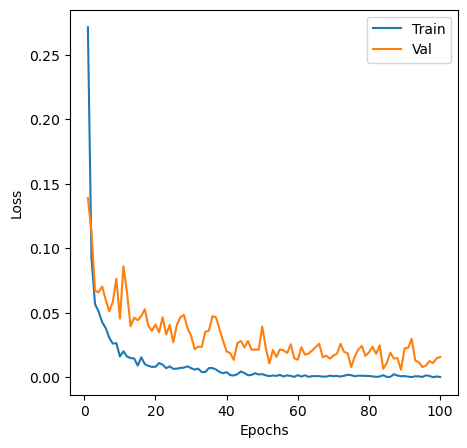

In [42]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Se crean los datasets y dataloaders
val_counts = val_df['label'].value_counts()
good_labels = val_counts[val_counts >= 2].index
val_df = val_df[val_df['label'].isin(good_labels)].reset_index(drop=True)
train_dataset, val_dataset, test_dataset, gallery_dataset = get_face_datasets(train_df, val_df, test_df, gallery_df, train_tfms["resnet"], eval_tfms["resnet"])
train_dataloader, val_dataloader, test_dataloader, gallery_dataloader = get_face_dataloaders(train_dataset, val_dataset, test_dataset, gallery_dataset , 32)

device = "cuda"
ext = ResNetExtractor( k_freeze=3, arch="resnet18").to(device)
# ext = InceptionExtractor(k_freeze=2).to(device)
# ext = ViTExtractor(name="vit_small_patch16_224", k_freeze=4).to(device)

# 2) EmbeddingHead recibe el extractor
embedder = EmbeddingHead(extractor=ext, emb_dim=128).to(device)

# 3) Pérdida y optimizador
criterion = TripletLoss(margin=1.0)
optimizer = torch.optim.AdamW(embedder.parameters(), lr=1e-4)  # asegurarte de tenerlo

# 4) plateau
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',            # bajamos la métrica
    factor=0.5,            # multiplicador del LR
    patience=5
) 
# 5) Loop
EPOCHS = 100


train_val(embedder, EPOCHS, train_dataloader, val_dataloader, device, optimizer, criterion, scheduler )







# Testing

In [43]:
import torch
import torch.nn.functional as F
import numpy as np

@torch.no_grad()
def evaluate_identification(model, gallery_loader, probe_loader, device, topk=(1,)):
    """
    Evalúa identificación 1-to-N.
    """
    model.eval()
    # 1) Extraer embeddings de la galería
    gal_embs, gal_labels = [], []
    for imgs, labels in gallery_loader:
        imgs = imgs.to(device)
        e = model(imgs)#F.normalize(model(imgs), dim=1)
        gal_embs.append(e.cpu())
        gal_labels.extend(labels.numpy() if isinstance(labels, torch.Tensor) else labels)
    gal_embs   = torch.cat(gal_embs, dim=0)                # [G, D]
    gal_labels = np.array(gal_labels)                      # [G]

    # 2) Extraer embeddings del probe set
    probe_embs, probe_labels = [], []
    for imgs, labels in probe_loader:
        imgs = imgs.to(device)
        e = model(imgs)#F.normalize(model(imgs), dim=1)
        probe_embs.append(e.cpu())
        probe_labels.extend(labels.numpy() if isinstance(labels, torch.Tensor) else labels)
    probe_embs   = torch.cat(probe_embs, dim=0)            # [P, D]
    probe_labels = np.array(probe_labels)                  # [P]

    # 3) Calcular distancias L2 entre cada probe y toda la galería
    #    resulta tensor [P, G]
    dists = torch.cdist(probe_embs, gal_embs, p=2).numpy()

    results = {}
    for k in topk:
        # índices de los k más cercanos
        nearest = np.argpartition(dists, kth=k-1, axis=1)[:, :k]  # [P, k]
        # labels de esos vecinos
        preds = gal_labels[nearest]                               # [P, k]
        # para top-1, la predicción es preds[:, 0]; para top-k, si label en fila
        if k == 1:
            correct = (preds[:, 0] == probe_labels)
        else:
            # comprueba si la etiqueta verdadera aparece en alguno de los k
            correct = np.any(preds == probe_labels[:, None], axis=1)
        results[f'top{k}'] = correct.mean()

    return results
metrics = evaluate_identification(embedder, gallery_dataloader, test_dataloader, device, topk=(1,5))
print(f"Top-1 Accuracy: {metrics['top1']:.2%}")
print(f"Top-5 Accuracy: {metrics['top5']:.2%}")

Top-1 Accuracy: 94.60%
Top-5 Accuracy: 98.58%


# Entrenamiento Inception

Epochs:   1%|          | 1/100 [00:38<1:03:08, 38.27s/it]

Epoch 1: LR=3.91e-07 — Train Loss=0.9436 — Val Loss=0.8526


Epochs:   2%|▏         | 2/100 [01:16<1:02:20, 38.17s/it]

Epoch 2: LR=3.91e-07 — Train Loss=0.9438 — Val Loss=0.8559


Epochs:   3%|▎         | 3/100 [01:54<1:01:41, 38.16s/it]

Epoch 3: LR=3.91e-07 — Train Loss=0.9476 — Val Loss=0.8644


Epochs:   4%|▍         | 4/100 [02:32<1:01:08, 38.22s/it]

Epoch 4: LR=3.91e-07 — Train Loss=0.9414 — Val Loss=0.8660


Epochs:   5%|▌         | 5/100 [03:10<1:00:26, 38.18s/it]

Epoch 5: LR=3.91e-07 — Train Loss=0.9449 — Val Loss=0.8645


Epochs:   6%|▌         | 6/100 [03:48<59:44, 38.13s/it]  

Epoch 6: LR=3.91e-07 — Train Loss=0.9444 — Val Loss=0.8605


Epochs:   7%|▋         | 7/100 [04:27<59:06, 38.14s/it]

Epoch 7: LR=1.95e-07 — Train Loss=0.9456 — Val Loss=0.8597


Epochs:   8%|▊         | 8/100 [05:05<58:28, 38.14s/it]

Epoch 8: LR=1.95e-07 — Train Loss=0.9438 — Val Loss=0.8600


Epochs:   9%|▉         | 9/100 [05:43<57:49, 38.13s/it]

Epoch 9: LR=1.95e-07 — Train Loss=0.9493 — Val Loss=0.8546


Epochs:  10%|█         | 10/100 [06:21<57:08, 38.10s/it]

Epoch 10: LR=1.95e-07 — Train Loss=0.9440 — Val Loss=0.8609


Epochs:  11%|█         | 11/100 [06:59<56:28, 38.07s/it]

Epoch 11: LR=1.95e-07 — Train Loss=0.9522 — Val Loss=0.8576


Epochs:  12%|█▏        | 12/100 [07:37<55:50, 38.08s/it]

Epoch 12: LR=1.95e-07 — Train Loss=0.9440 — Val Loss=0.8541


Epochs:  13%|█▎        | 13/100 [08:15<55:12, 38.08s/it]

Epoch 13: LR=9.77e-08 — Train Loss=0.9431 — Val Loss=0.8632


Epochs:  14%|█▍        | 14/100 [08:53<54:37, 38.11s/it]

Epoch 14: LR=9.77e-08 — Train Loss=0.9479 — Val Loss=0.8654


Epochs:  15%|█▌        | 15/100 [09:31<54:01, 38.13s/it]

Epoch 15: LR=9.77e-08 — Train Loss=0.9432 — Val Loss=0.8627


Epochs:  16%|█▌        | 16/100 [10:10<53:23, 38.13s/it]

Epoch 16: LR=9.77e-08 — Train Loss=0.9473 — Val Loss=0.8596


Epochs:  17%|█▋        | 17/100 [10:48<52:46, 38.15s/it]

Epoch 17: LR=9.77e-08 — Train Loss=0.9460 — Val Loss=0.8511


Epochs:  18%|█▊        | 18/100 [11:26<52:08, 38.16s/it]

Epoch 18: LR=9.77e-08 — Train Loss=0.9450 — Val Loss=0.8695


Epochs:  19%|█▉        | 19/100 [12:04<51:27, 38.12s/it]

Epoch 19: LR=4.88e-08 — Train Loss=0.9462 — Val Loss=0.8555


Epochs:  20%|██        | 20/100 [12:42<50:45, 38.06s/it]

Epoch 20: LR=4.88e-08 — Train Loss=0.9448 — Val Loss=0.8559


Epochs:  21%|██        | 21/100 [13:20<50:03, 38.02s/it]

Epoch 21: LR=4.88e-08 — Train Loss=0.9453 — Val Loss=0.8517


Epochs:  22%|██▏       | 22/100 [13:58<49:27, 38.04s/it]

Epoch 22: LR=4.88e-08 — Train Loss=0.9451 — Val Loss=0.8654


Epochs:  23%|██▎       | 23/100 [14:36<48:48, 38.04s/it]

Epoch 23: LR=4.88e-08 — Train Loss=0.9442 — Val Loss=0.8540


Epochs:  24%|██▍       | 24/100 [15:14<48:13, 38.08s/it]

Epoch 24: LR=4.88e-08 — Train Loss=0.9458 — Val Loss=0.8655


Epochs:  25%|██▌       | 25/100 [15:52<47:37, 38.11s/it]

Epoch 25: LR=2.44e-08 — Train Loss=0.9446 — Val Loss=0.8554


Epochs:  26%|██▌       | 26/100 [16:30<46:59, 38.10s/it]

Epoch 26: LR=2.44e-08 — Train Loss=0.9476 — Val Loss=0.8621


Epochs:  27%|██▋       | 27/100 [17:09<46:22, 38.11s/it]

Epoch 27: LR=2.44e-08 — Train Loss=0.9428 — Val Loss=0.8588


Epochs:  28%|██▊       | 28/100 [17:47<45:48, 38.17s/it]

Epoch 28: LR=2.44e-08 — Train Loss=0.9452 — Val Loss=0.8604


Epochs:  29%|██▉       | 29/100 [18:25<45:05, 38.11s/it]

Epoch 29: LR=2.44e-08 — Train Loss=0.9477 — Val Loss=0.8622


Epochs:  30%|███       | 30/100 [19:03<44:28, 38.12s/it]

Epoch 30: LR=2.44e-08 — Train Loss=0.9503 — Val Loss=0.8553


Epochs:  31%|███       | 31/100 [19:41<43:49, 38.11s/it]

Epoch 31: LR=1.22e-08 — Train Loss=0.9476 — Val Loss=0.8610


Epochs:  32%|███▏      | 32/100 [20:19<43:10, 38.10s/it]

Epoch 32: LR=1.22e-08 — Train Loss=0.9439 — Val Loss=0.8699


Epochs:  33%|███▎      | 33/100 [20:57<42:32, 38.09s/it]

Epoch 33: LR=1.22e-08 — Train Loss=0.9408 — Val Loss=0.8569


Epochs:  34%|███▍      | 34/100 [21:35<41:54, 38.11s/it]

Epoch 34: LR=1.22e-08 — Train Loss=0.9429 — Val Loss=0.8585


Epochs:  35%|███▌      | 35/100 [22:13<41:16, 38.10s/it]

Epoch 35: LR=1.22e-08 — Train Loss=0.9425 — Val Loss=0.8649


Epochs:  36%|███▌      | 36/100 [22:51<40:38, 38.10s/it]

Epoch 36: LR=1.22e-08 — Train Loss=0.9451 — Val Loss=0.8606


Epochs:  37%|███▋      | 37/100 [23:30<40:00, 38.11s/it]

Epoch 37: LR=1.22e-08 — Train Loss=0.9433 — Val Loss=0.8661


Epochs:  38%|███▊      | 38/100 [24:08<39:23, 38.11s/it]

Epoch 38: LR=1.22e-08 — Train Loss=0.9471 — Val Loss=0.8599


Epochs:  39%|███▉      | 39/100 [24:46<38:43, 38.09s/it]

Epoch 39: LR=1.22e-08 — Train Loss=0.9498 — Val Loss=0.8662


Epochs:  40%|████      | 40/100 [25:24<38:04, 38.08s/it]

Epoch 40: LR=1.22e-08 — Train Loss=0.9462 — Val Loss=0.8587


Epochs:  41%|████      | 41/100 [26:02<37:27, 38.09s/it]

Epoch 41: LR=1.22e-08 — Train Loss=0.9441 — Val Loss=0.8654


Epochs:  42%|████▏     | 42/100 [26:40<36:50, 38.11s/it]

Epoch 42: LR=1.22e-08 — Train Loss=0.9484 — Val Loss=0.8635


Epochs:  43%|████▎     | 43/100 [27:18<36:12, 38.11s/it]

Epoch 43: LR=1.22e-08 — Train Loss=0.9478 — Val Loss=0.8619


Epochs:  44%|████▍     | 44/100 [27:56<35:33, 38.09s/it]

Epoch 44: LR=1.22e-08 — Train Loss=0.9478 — Val Loss=0.8659


Epochs:  45%|████▌     | 45/100 [28:34<34:56, 38.12s/it]

Epoch 45: LR=1.22e-08 — Train Loss=0.9504 — Val Loss=0.8600


Epochs:  46%|████▌     | 46/100 [29:13<34:18, 38.12s/it]

Epoch 46: LR=1.22e-08 — Train Loss=0.9408 — Val Loss=0.8654


Epochs:  47%|████▋     | 47/100 [29:51<33:38, 38.09s/it]

Epoch 47: LR=1.22e-08 — Train Loss=0.9476 — Val Loss=0.8585


Epochs:  48%|████▊     | 48/100 [30:29<32:58, 38.05s/it]

Epoch 48: LR=1.22e-08 — Train Loss=0.9431 — Val Loss=0.8574


Epochs:  49%|████▉     | 49/100 [31:07<32:21, 38.06s/it]

Epoch 49: LR=1.22e-08 — Train Loss=0.9456 — Val Loss=0.8605


Epochs:  50%|█████     | 50/100 [31:45<31:43, 38.08s/it]

Epoch 50: LR=1.22e-08 — Train Loss=0.9414 — Val Loss=0.8638


Epochs:  51%|█████     | 51/100 [32:23<31:07, 38.11s/it]

Epoch 51: LR=1.22e-08 — Train Loss=0.9448 — Val Loss=0.8475


Epochs:  52%|█████▏    | 52/100 [33:01<30:29, 38.11s/it]

Epoch 52: LR=1.22e-08 — Train Loss=0.9455 — Val Loss=0.8664


Epochs:  53%|█████▎    | 53/100 [33:39<29:51, 38.12s/it]

Epoch 53: LR=1.22e-08 — Train Loss=0.9513 — Val Loss=0.8638


Epochs:  54%|█████▍    | 54/100 [34:17<29:14, 38.14s/it]

Epoch 54: LR=1.22e-08 — Train Loss=0.9439 — Val Loss=0.8581


Epochs:  55%|█████▌    | 55/100 [34:56<28:38, 38.20s/it]

Epoch 55: LR=1.22e-08 — Train Loss=0.9494 — Val Loss=0.8549


Epochs:  56%|█████▌    | 56/100 [35:34<27:59, 38.17s/it]

Epoch 56: LR=1.22e-08 — Train Loss=0.9440 — Val Loss=0.8619


Epochs:  57%|█████▋    | 57/100 [36:12<27:19, 38.14s/it]

Epoch 57: LR=1.22e-08 — Train Loss=0.9508 — Val Loss=0.8585


Epochs:  58%|█████▊    | 58/100 [36:50<26:39, 38.08s/it]

Epoch 58: LR=1.22e-08 — Train Loss=0.9527 — Val Loss=0.8708


Epochs:  59%|█████▉    | 59/100 [37:28<25:59, 38.05s/it]

Epoch 59: LR=1.22e-08 — Train Loss=0.9501 — Val Loss=0.8655


Epochs:  60%|██████    | 60/100 [38:06<25:21, 38.05s/it]

Epoch 60: LR=1.22e-08 — Train Loss=0.9488 — Val Loss=0.8692


Epochs:  61%|██████    | 61/100 [38:44<24:44, 38.06s/it]

Epoch 61: LR=1.22e-08 — Train Loss=0.9456 — Val Loss=0.8653


Epochs:  62%|██████▏   | 62/100 [39:22<24:07, 38.08s/it]

Epoch 62: LR=1.22e-08 — Train Loss=0.9433 — Val Loss=0.8608


Epochs:  63%|██████▎   | 63/100 [40:00<23:29, 38.10s/it]

Epoch 63: LR=1.22e-08 — Train Loss=0.9432 — Val Loss=0.8593


Epochs:  64%|██████▍   | 64/100 [40:38<22:52, 38.12s/it]

Epoch 64: LR=1.22e-08 — Train Loss=0.9449 — Val Loss=0.8641


Epochs:  65%|██████▌   | 65/100 [41:17<22:14, 38.12s/it]

Epoch 65: LR=1.22e-08 — Train Loss=0.9443 — Val Loss=0.8599


Epochs:  66%|██████▌   | 66/100 [41:55<21:36, 38.13s/it]

Epoch 66: LR=1.22e-08 — Train Loss=0.9433 — Val Loss=0.8587


Epochs:  67%|██████▋   | 67/100 [42:33<20:58, 38.13s/it]

Epoch 67: LR=1.22e-08 — Train Loss=0.9411 — Val Loss=0.8645


Epochs:  68%|██████▊   | 68/100 [43:11<20:19, 38.10s/it]

Epoch 68: LR=1.22e-08 — Train Loss=0.9408 — Val Loss=0.8645


Epochs:  69%|██████▉   | 69/100 [43:49<19:41, 38.10s/it]

Epoch 69: LR=1.22e-08 — Train Loss=0.9456 — Val Loss=0.8599


Epochs:  70%|███████   | 70/100 [44:27<19:02, 38.08s/it]

Epoch 70: LR=1.22e-08 — Train Loss=0.9482 — Val Loss=0.8666


Epochs:  71%|███████   | 71/100 [45:05<18:24, 38.08s/it]

Epoch 71: LR=1.22e-08 — Train Loss=0.9420 — Val Loss=0.8693


Epochs:  72%|███████▏  | 72/100 [45:43<17:45, 38.05s/it]

Epoch 72: LR=1.22e-08 — Train Loss=0.9459 — Val Loss=0.8545


Epochs:  73%|███████▎  | 73/100 [46:21<17:06, 38.02s/it]

Epoch 73: LR=1.22e-08 — Train Loss=0.9462 — Val Loss=0.8623


Epochs:  74%|███████▍  | 74/100 [46:59<16:28, 38.02s/it]

Epoch 74: LR=1.22e-08 — Train Loss=0.9473 — Val Loss=0.8610


Epochs:  75%|███████▌  | 75/100 [47:37<15:51, 38.06s/it]

Epoch 75: LR=1.22e-08 — Train Loss=0.9438 — Val Loss=0.8593


Epochs:  76%|███████▌  | 76/100 [48:15<15:14, 38.10s/it]

Epoch 76: LR=1.22e-08 — Train Loss=0.9490 — Val Loss=0.8648


Epochs:  77%|███████▋  | 77/100 [48:53<14:36, 38.09s/it]

Epoch 77: LR=1.22e-08 — Train Loss=0.9465 — Val Loss=0.8661


Epochs:  78%|███████▊  | 78/100 [49:32<13:58, 38.11s/it]

Epoch 78: LR=1.22e-08 — Train Loss=0.9473 — Val Loss=0.8643


Epochs:  79%|███████▉  | 79/100 [50:10<13:20, 38.12s/it]

Epoch 79: LR=1.22e-08 — Train Loss=0.9448 — Val Loss=0.8660


Epochs:  80%|████████  | 80/100 [50:48<12:42, 38.13s/it]

Epoch 80: LR=1.22e-08 — Train Loss=0.9407 — Val Loss=0.8660


Epochs:  81%|████████  | 81/100 [51:26<12:04, 38.14s/it]

Epoch 81: LR=1.22e-08 — Train Loss=0.9423 — Val Loss=0.8611


Epochs:  82%|████████▏ | 82/100 [52:04<11:26, 38.11s/it]

Epoch 82: LR=1.22e-08 — Train Loss=0.9438 — Val Loss=0.8660


Epochs:  83%|████████▎ | 83/100 [52:42<10:48, 38.14s/it]

Epoch 83: LR=1.22e-08 — Train Loss=0.9448 — Val Loss=0.8581


Epochs:  84%|████████▍ | 84/100 [53:20<10:10, 38.15s/it]

Epoch 84: LR=1.22e-08 — Train Loss=0.9495 — Val Loss=0.8563


Epochs:  85%|████████▌ | 85/100 [53:58<09:31, 38.11s/it]

Epoch 85: LR=1.22e-08 — Train Loss=0.9417 — Val Loss=0.8528


Epochs:  86%|████████▌ | 86/100 [54:36<08:53, 38.08s/it]

Epoch 86: LR=1.22e-08 — Train Loss=0.9434 — Val Loss=0.8611


Epochs:  87%|████████▋ | 87/100 [55:15<08:15, 38.09s/it]

Epoch 87: LR=1.22e-08 — Train Loss=0.9463 — Val Loss=0.8630


Epochs:  88%|████████▊ | 88/100 [55:53<07:37, 38.09s/it]

Epoch 88: LR=1.22e-08 — Train Loss=0.9476 — Val Loss=0.8589


Epochs:  89%|████████▉ | 89/100 [56:31<06:59, 38.12s/it]

Epoch 89: LR=1.22e-08 — Train Loss=0.9444 — Val Loss=0.8630


Epochs:  90%|█████████ | 90/100 [57:09<06:21, 38.13s/it]

Epoch 90: LR=1.22e-08 — Train Loss=0.9423 — Val Loss=0.8576


Epochs:  91%|█████████ | 91/100 [57:47<05:43, 38.14s/it]

Epoch 91: LR=1.22e-08 — Train Loss=0.9471 — Val Loss=0.8575


Epochs:  92%|█████████▏| 92/100 [58:25<05:05, 38.15s/it]

Epoch 92: LR=1.22e-08 — Train Loss=0.9425 — Val Loss=0.8632


Epochs:  93%|█████████▎| 93/100 [59:04<04:27, 38.16s/it]

Epoch 93: LR=1.22e-08 — Train Loss=0.9455 — Val Loss=0.8624


Epochs:  94%|█████████▍| 94/100 [59:42<03:49, 38.17s/it]

Epoch 94: LR=1.22e-08 — Train Loss=0.9501 — Val Loss=0.8582


Epochs:  95%|█████████▌| 95/100 [1:00:20<03:10, 38.13s/it]

Epoch 95: LR=1.22e-08 — Train Loss=0.9402 — Val Loss=0.8718


Epochs:  96%|█████████▌| 96/100 [1:00:58<02:32, 38.09s/it]

Epoch 96: LR=1.22e-08 — Train Loss=0.9475 — Val Loss=0.8615


Epochs:  97%|█████████▋| 97/100 [1:01:36<01:54, 38.09s/it]

Epoch 97: LR=1.22e-08 — Train Loss=0.9456 — Val Loss=0.8700


Epochs:  98%|█████████▊| 98/100 [1:02:14<01:16, 38.07s/it]

Epoch 98: LR=1.22e-08 — Train Loss=0.9479 — Val Loss=0.8664


Epochs:  99%|█████████▉| 99/100 [1:02:52<00:38, 38.07s/it]

Epoch 99: LR=1.22e-08 — Train Loss=0.9453 — Val Loss=0.8593


Epochs: 100%|██████████| 100/100 [1:03:30<00:00, 38.11s/it]

Epoch 100: LR=1.22e-08 — Train Loss=0.9417 — Val Loss=0.8539


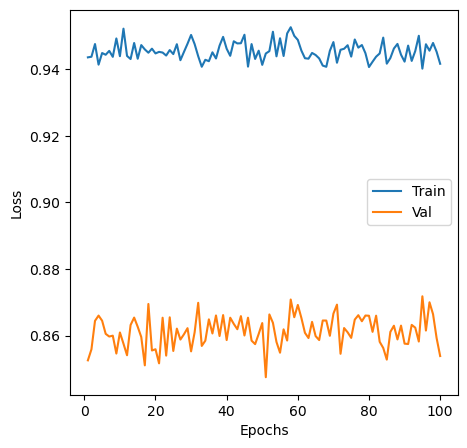

In [44]:
train_dataset, val_dataset, test_dataset, gallery_dataset = get_face_datasets(train_df, val_df, test_df, gallery_df, train_tfms["inception"], eval_tfms["inception"])
train_dataloader, val_dataloader, test_dataloader, gallery_dataloader = get_face_dataloaders(train_dataset, val_dataset, test_dataset, gallery_dataset ,  32)
ext_inception = InceptionExtractor(k_freeze=2).to(device)
embedder_inception = EmbeddingHead(extractor=ext_inception, emb_dim=128).to(device)
train_val(embedder_inception , EPOCHS, train_dataloader, val_dataloader, device, optimizer, criterion, scheduler )

# Testinginception

In [46]:
metrics_inception = evaluate_identification(embedder_inception, gallery_dataloader, test_dataloader, device, topk=(1,5))
print(f"Top-1 Accuracy: {metrics_inception ['top1']:.2%}")
print(f"Top-5 Accuracy: {metrics_inception ['top5']:.2%}")

Top-1 Accuracy: 53.98%
Top-5 Accuracy: 72.16%


In [ ]:
# Transformers 